## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from agents.utils import get_config, smooth
from agents.agents import DeepQAgent
from tqdm.auto import tqdm

In [2]:
# Set global variables
WEIGHTS_PATH = 'agents/weights/pretrained_network.pt'

######################################## Define this as explained in README.md###########################################
BANANA_PATH = 'environment/banana_windows/Banana.exe'
#########################################################################################################################

NUM_EPISODES = 5000

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [3]:
# Initialize agent and environment
agent_config = get_config()
agent = DeepQAgent(config=agent_config)
env = UnityEnvironment(file_name=BANANA_PATH)

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Training Day

In [4]:
# A function used to play one episode with a given agent
def play_one(agent, env, brain_name, train_mode=True):
    
    # Initialize the return
    episode_return = 0
    
    # Start episode
    env_info = env.reset(train_mode=train_mode)[brain_name]
    observation = env_info.vector_observations[0]
    done = False
    
    # Play
    while not done:
        # Interact with environment
        action = agent.act(observation)
        env_info = env.step(action)[brain_name]
        next_observation = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        episode_return += reward     

        # Add memory
        agent.memento(observation, action, reward, next_observation, done)
        # Train from memory
        agent.learn()
        
        # Perform transition
        observation = next_observation
    
    return episode_return

In [5]:
# Populating replay buffer:
env_info = env.reset(train_mode=True)[brain_name]
observation = env_info.vector_observations[0]
done = False

print('Filling Replay Buffer...')
while not agent.memory.is_ready():
    action = np.random.choice(4)
    action = agent.act(observation)
    env_info = env.step(action)[brain_name]
    reward = env_info.rewards[0]
    next_observation = env_info.vector_observations[0]
    done = env_info.local_done[0]

    # Add memory
    agent.memento(observation, action, reward, next_observation, done)
    
    if done:
        env_info = env.reset(train_mode=True)[brain_name]
        observation = env_info.vector_observations[0]

# Now we are able to train our agent
episode_returns = np.zeros(NUM_EPISODES)

print('Starting Training...')
for i in tqdm(range(NUM_EPISODES)):
    episode_returns[i] = play_one(agent, env, brain_name)
    if i % (NUM_EPISODES // 10) == 0 and i > 0:
        print(f'Average Return over the last 100 episodes: {smooth(episode_returns[:i+1])[-1]}')

Filling Replay Buffer...
Starting Training...


Average Return over the last 100 episodes: 12.49
Average Return over the last 100 episodes: 12.67
Average Return over the last 100 episodes: 12.17
Average Return over the last 100 episodes: 12.79
Average Return over the last 100 episodes: 12.98
Average Return over the last 100 episodes: 12.33
Average Return over the last 100 episodes: 12.33
Average Return over the last 100 episodes: 12.04
Average Return over the last 100 episodes: 12.95



Over the last 100 episodes, the agent received an average return of 12.29


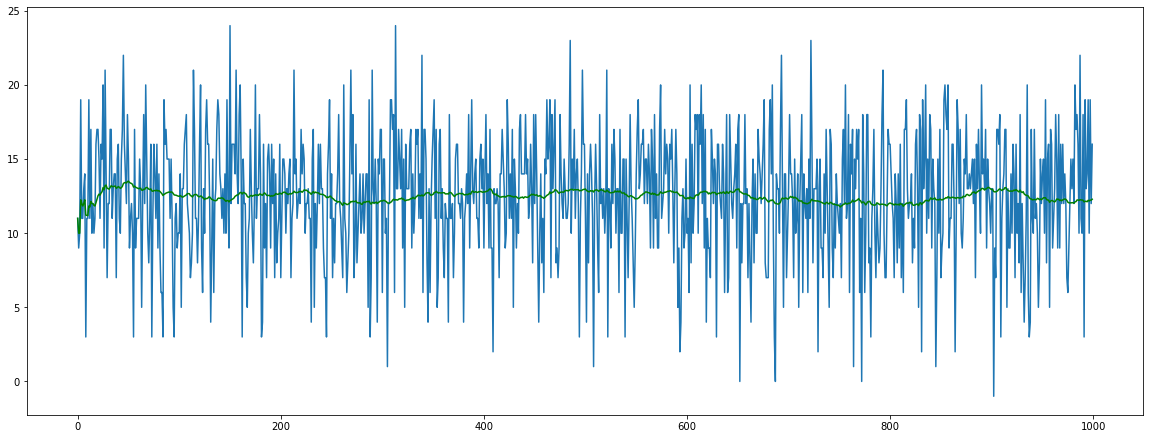

In [6]:
# Plot the results:
plt.figure(figsize=(20,7.5))
plt.plot(episode_returns)
plt.plot(smooth(episode_returns), color='green')

# Print the return over the last 100 episodes:
print(f'Over the last 100 episodes, the agent received an average return of {smooth(episode_returns)[-1]}')

In [7]:
# Save weights
agent.save(WEIGHTS_PATH)

## Evaluate

In [8]:
# Set exploration to zero:
agent.epsilon = 0
# Play 100 episodes and print the average reward (repeated for 10 runs):
for i in tqdm(range(10)):
    cache = np.zeros(100)
    for j in range(100):
        cache[j] = play_one(agent, env, brain_name)
    print(f'In run {i+1} the Agent received an average return of {np.mean(cache)} over 100 episodes.')

In run 1 the Agent received an average return of 11.75 over 100 episodes.
In run 2 the Agent received an average return of 12.84 over 100 episodes.
In run 3 the Agent received an average return of 12.24 over 100 episodes.
In run 4 the Agent received an average return of 12.82 over 100 episodes.
In run 5 the Agent received an average return of 12.1 over 100 episodes.
In run 6 the Agent received an average return of 12.6 over 100 episodes.
In run 7 the Agent received an average return of 11.89 over 100 episodes.
In run 8 the Agent received an average return of 12.7 over 100 episodes.
In run 9 the Agent received an average return of 12.9 over 100 episodes.
In run 10 the Agent received an average return of 12.42 over 100 episodes.



## Watch

In [9]:
# Watch Time
play_one(agent, env, brain_name, train_mode=False)

18.0

## Clean up

In [10]:
# Shutdown
env.close()